In [31]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import common

In [32]:
root_dir = Path("../data_out/langmuir/finn_different_seeds")
# root_dir = Path("../data_out/langmuir/finn_different_loss_patterns")
# root_dir = Path("../data_out/langmuir/finn_c_plus_better_noise")

In [33]:
records = []

for loss_path in root_dir.rglob("loss.txt"):
    finn_dir = loss_path.parent
    isotherm = "langmuir" if "langmuir" in str(finn_dir) else "freundlich"
    
    try:
        c_train = np.load(finn_dir / "c_train.npy")
        c_train_pred = np.load(finn_dir / "c_train_predictions.npy")
        c_full = np.load(finn_dir / "c_full.npy")
        c_full_pred = np.load(finn_dir / "c_full_predictions.npy")
        mse_c_train = np.square(c_train - c_train_pred).mean()
        mse_c_full = np.square(c_full - c_full_pred).mean()
    except FileNotFoundError:
        mse_c_train = np.nan
        mse_c_full = np.nan

    records.append({
        "finn_dir": finn_dir,
        "isotherm": isotherm,
        "finn_dir_label": finn_dir.name.split("_")[0],
        "epochs": len(np.loadtxt(finn_dir / "loss.txt")),
        "MSE(c_train, c_train_pred)": mse_c_train,
        "MSE(c_full, c_full_pred)": mse_c_full,
    })

finn_dir_df = pd.DataFrame.from_records(records)
display(len(finn_dir_df))
display(finn_dir_df.dtypes)
display(finn_dir_df.head())

16

finn_dir                       object
isotherm                       object
finn_dir_label                 object
epochs                          int64
MSE(c_train, c_train_pred)    float64
MSE(c_full, c_full_pred)      float64
dtype: object

,finn_dir,isotherm,finn_dir_label,epochs,"MSE(c_train, c_train_pred)","MSE(c_full, c_full_pred)"
0,../data_out/langmuir/finn_different_seeds/9612...,langmuir,961208825,100,4.250073e-11,3.290894e-10
1,../data_out/langmuir/finn_different_seeds/4542...,langmuir,454289274,100,1.130149e-09,8.936901e-09
2,../data_out/langmuir/finn_different_seeds/5024...,langmuir,502465336,100,3.705947e-11,1.911080e-09
3,../data_out/langmuir/finn_different_seeds/4778...,langmuir,477890484,100,3.824679e-11,1.085318e-09
4,../data_out/langmuir/finn_different_seeds/6689...,langmuir,668948095,100,3.205543e-10,8.475120e-09


In [34]:
# def has_finn_converged(finn_dir_df_row):
#     row = finn_dir_df_row
#     has_converged = True
#     if 

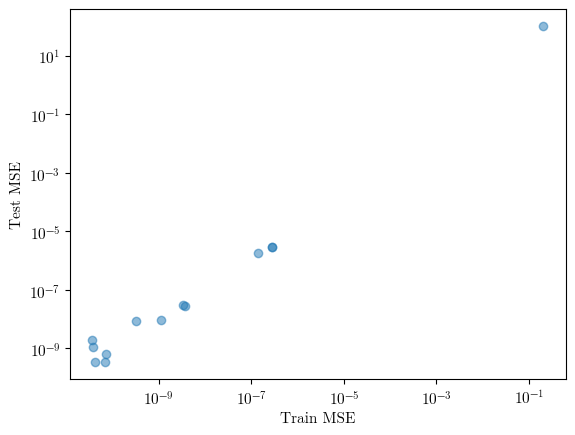

In [35]:
# tmp_mask = (finn_dir_df["MSE(c_train, c_train_pred)"] < 1e-4) & (finn_dir_df["MSE(c_train, c_train_pred)"] > 5e-6)
tmp_mask = np.ones(len(finn_dir_df), dtype=bool)
plt.scatter(finn_dir_df["MSE(c_train, c_train_pred)"][tmp_mask], finn_dir_df["MSE(c_full, c_full_pred)"][tmp_mask], alpha=0.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Train MSE")
plt.ylabel("Test MSE")
plt.show()

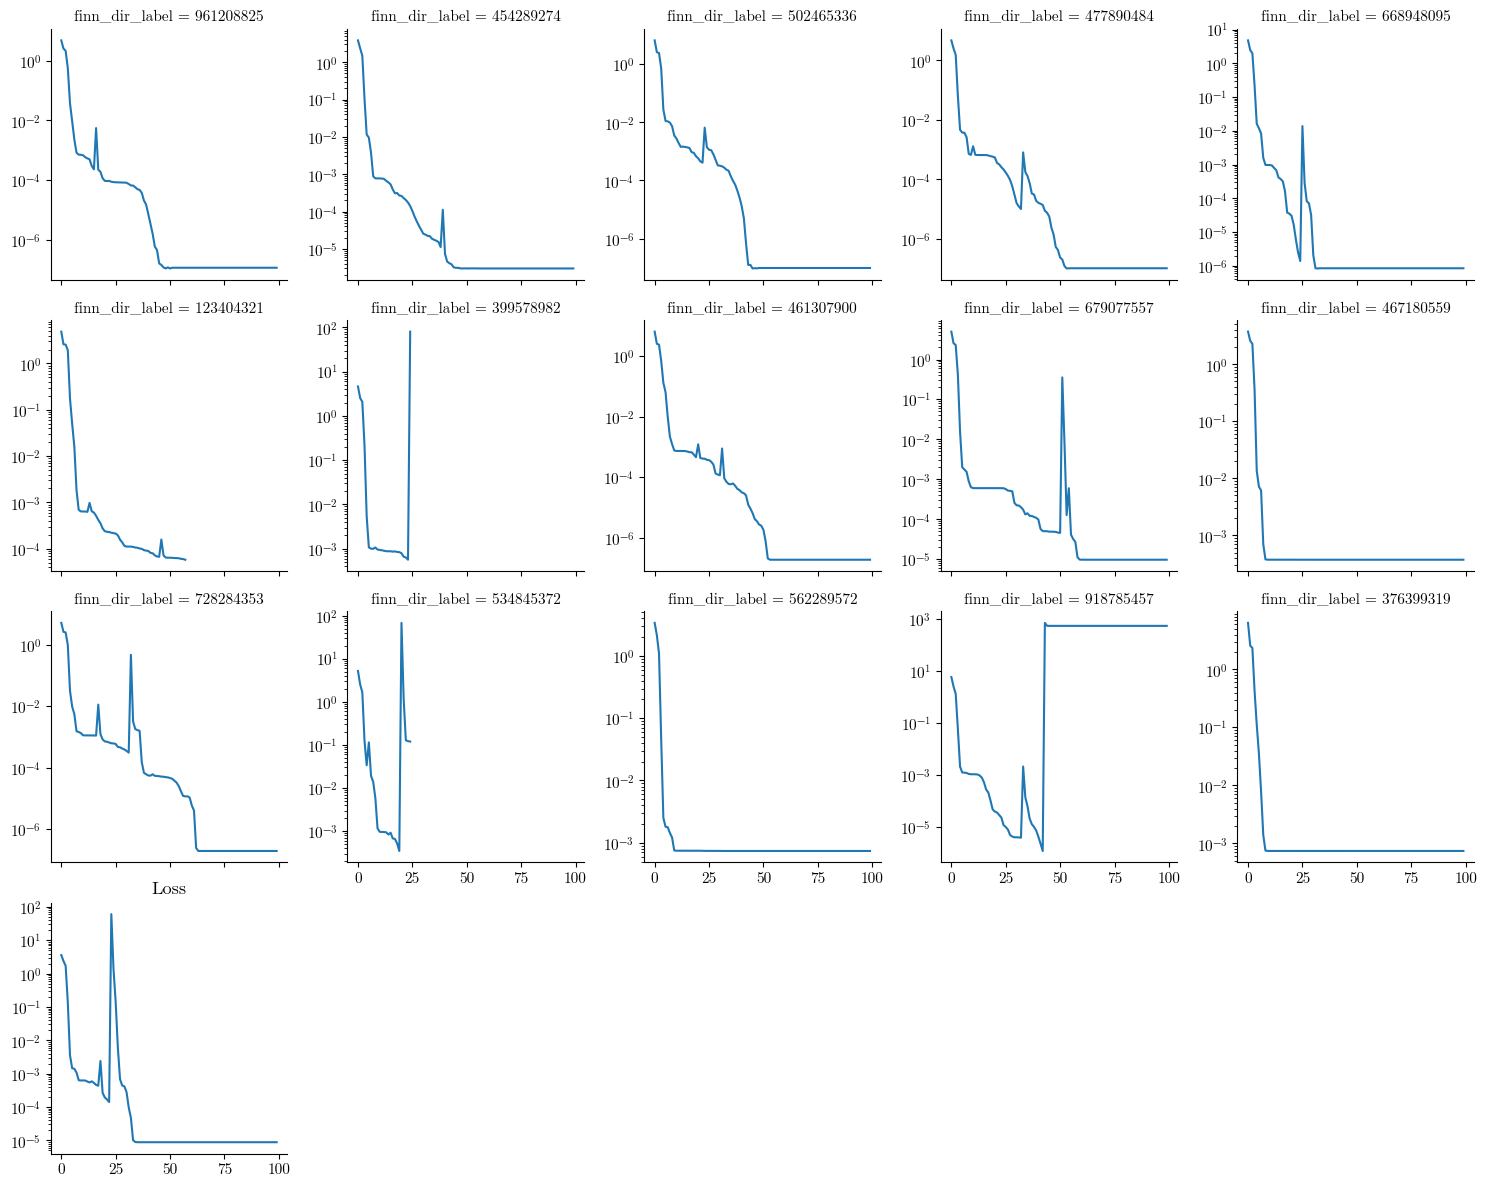

In [36]:
def load_and_plot(data, *args, **kwargs):
    y = np.loadtxt(data["finn_dir"].iloc[0] / "loss.txt")
    plt.semilogy(y, *args, **kwargs)

g = sns.FacetGrid(
    data=finn_dir_df,
    col="finn_dir_label",
    col_wrap=5,
    sharey=False,
)

g.map_dataframe(load_and_plot)
plt.title("Loss")
plt.show()

In [37]:
def load_analytic_retardation(finn_dir_df_row):
    return np.load(
        finn_dir_df_row["finn_dir"] / f"retardation_{finn_dir_df_row['isotherm']}.npy"
    )

## Final Retardation vs Best Retardation

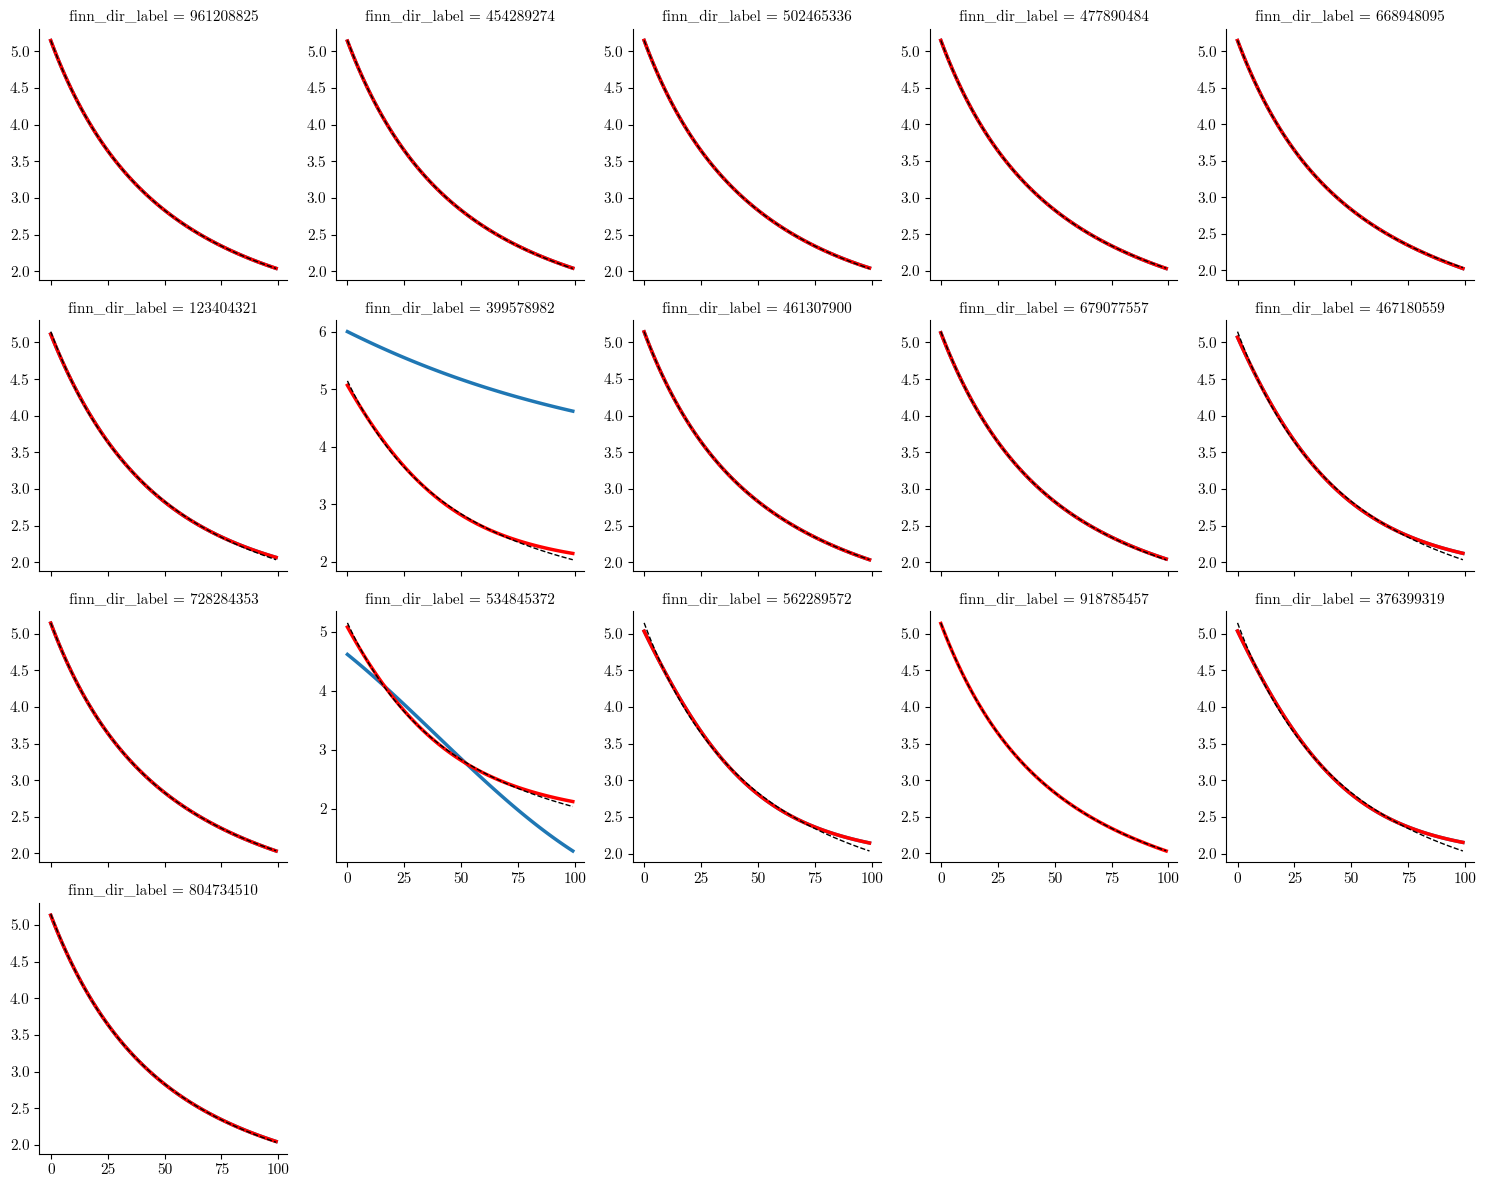

In [38]:
def final_retardation(finn_dir: Path):
    all_rets = sorted([p for p in (finn_dir / "predicted_retardations").iterdir()], key=lambda x: int(x.stem.split("_")[-1]))
    if not all_rets:
        return None
    return all_rets[-1]

def best_retardation(finn_dir: Path):
    best_epoch = np.loadtxt(finn_dir / "loss.txt").argmin() + 1
    p = finn_dir / f"predicted_retardations/retPred_{best_epoch}.npy"
    if p.exists():
        return p
    return None

def load_and_plot(data, *args, **kwargs):
    assert len(data) == 1
    y = np.load(final_retardation(data["finn_dir"].iloc[0]))
    y_best = np.load(best_retardation(data["finn_dir"].iloc[0]))
    isotherm = data["isotherm"].iloc[0]
    plt.plot(y, *args, lw=2.5, **kwargs)
    plt.plot(y_best, "r-", lw=2.5)
    y_min, y_max = plt.ylim()  # get limits before plotting the analytical retardation
    plt.plot(load_analytic_retardation(data.iloc[0]), "k--", lw=1.0, label=isotherm.capitalize())
    if isotherm == "freundlich":
        plt.ylim(min(3, y_min), max(5, y_max))
    # plt.legend()

g = sns.FacetGrid(
    data=finn_dir_df,
    col="finn_dir_label",
    col_wrap=5,
    hue="isotherm",
    sharey=False
)

g.map_dataframe(load_and_plot)
plt.show()

In [39]:
finn_dir_df

,finn_dir,isotherm,finn_dir_label,epochs,"MSE(c_train, c_train_pred)","MSE(c_full, c_full_pred)"
0,../data_out/langmuir/finn_different_seeds/9612...,langmuir,961208825,100,4.250073e-11,3.290894e-10
1,../data_out/langmuir/finn_different_seeds/4542...,langmuir,454289274,100,1.130149e-09,8.936901e-09
2,../data_out/langmuir/finn_different_seeds/5024...,langmuir,502465336,100,3.705947e-11,1.911080e-09
3,../data_out/langmuir/finn_different_seeds/4778...,langmuir,477890484,100,3.824679e-11,1.085318e-09
4,../data_out/langmuir/finn_different_seeds/6689...,langmuir,668948095,100,3.205543e-10,8.475120e-09
5,../data_out/langmuir/finn_different_seeds/1234...,langmuir,123404321,58,NaN,NaN
6,../data_out/langmuir/finn_different_seeds/3995...,langmuir,399578982,25,NaN,NaN
7,../data_out/langmuir/finn_different_seeds/4613...,langmuir,461307900,100,6.999332e-11,3.275391e-10
8,../data_out/langmuir/finn_different_seeds/6790...,langmuir,679077557,100,3.636025e-09,2.863680e-08
9,../data_out/langmuir/finn_different_seeds/4671...,langmuir,467180559,100,1.412015e-07,1.734051e-06


In [40]:
[str(p) for p in finn_dir_df["finn_dir"]]

['../data_out/langmuir/finn_different_seeds/961208825_finn_different_seeds',
 '../data_out/langmuir/finn_different_seeds/454289274_finn_different_seeds',
 '../data_out/langmuir/finn_different_seeds/502465336_finn_different_seeds',
 '../data_out/langmuir/finn_different_seeds/477890484_finn_different_seeds',
 '../data_out/langmuir/finn_different_seeds/668948095_finn_different_seeds',
 '../data_out/langmuir/finn_different_seeds/123404321_finn_different_seeds',
 '../data_out/langmuir/finn_different_seeds/399578982_finn_different_seeds',
 '../data_out/langmuir/finn_different_seeds/461307900_finn_different_seeds',
 '../data_out/langmuir/finn_different_seeds/679077557_finn_different_seeds',
 '../data_out/langmuir/finn_different_seeds/467180559_finn_different_seeds',
 '../data_out/langmuir/finn_different_seeds/728284353_finn_different_seeds',
 '../data_out/langmuir/finn_different_seeds/534845372_finn_different_seeds',
 '../data_out/langmuir/finn_different_seeds/562289572_finn_different_seeds',

In [41]:
print(len(finn_dir_df))
filtered_finn_dir_df = finn_dir_df.copy()
# filtered_finn_dir_df = finn_dir_df[[("sigma=0.004" in str(p)) or ("sigma=0.002" in str(p)) for p in finn_dir_df["finn_dir"]]]
# filtered_finn_dir_df = finn_dir_df[[("sigma=0.016" in str(p)) or ("sigma=0.032" in str(p)) for p in finn_dir_df["finn_dir"]]]
# filtered_finn_dir_df = filtered_finn_dir_df[filtered_finn_dir_df["MSE(c_full, c_full_pred)"] < 1e-3]
print(len(filtered_finn_dir_df))

16
16


In [42]:
finn_dir_df["MSE(c_train, c_train_pred)"]

0     4.250073e-11
1     1.130149e-09
2     3.705947e-11
3     3.824679e-11
4     3.205543e-10
5              NaN
6              NaN
7     6.999332e-11
8     3.636025e-09
9     1.412015e-07
10    7.316719e-11
11             NaN
12    2.782975e-07
13    2.048133e-01
14    2.802355e-07
15    3.324355e-09
Name: MSE(c_train, c_train_pred), dtype: float64

In [43]:
filtered_finn_dir_df = finn_dir_df[finn_dir_df["MSE(c_train, c_train_pred)"] < 0.0012]

In [44]:
import plotting

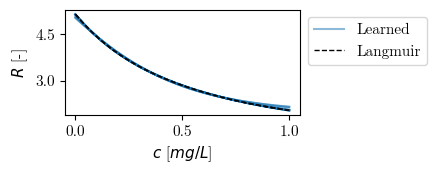

In [45]:
fig, ax = plt.subplots(figsize=(1.5*plotting.FIGURE_WIDTH, plotting.FIGURE_HEIGHT))

for i, row in filtered_finn_dir_df.iterrows():
    # ret = np.load(final_retardation(row["finn_dir"]))
    ret = np.load(best_retardation(row["finn_dir"]))
    u = np.linspace(0, 1, len(ret))
    if np.any(ret > 10):
        continue
    if np.any(ret < 1):
        continue
    isotherm = row["isotherm"]
    ax.plot(u, ret, color="tab:blue", alpha=0.5, label="Learned" if i == 0 else "")
    y_min, y_max = plt.ylim()  # get limits before plotting the analytical retardation
    
    ax.plot(u, load_analytic_retardation(row), "k--", lw=1.0, label=isotherm.capitalize() if i == 0 else "")
    if isotherm == "freundlich":
        ax.set_ylim(min(3, y_min), max(5, y_max))

ax.legend(loc="upper left", bbox_to_anchor=(1,1))

plotting.set_retardation_axes_stuff(ax, set_xlabel=True, set_ylabel=True)
plt.tight_layout()
plotting.savefig(fig, "../paper/figs/finn_synthetic_SPAN_seed")
# plotting.savefig(fig, "../paper/figs/finn_synthetic_SPAN_losspattern")
# plotting.savefig(fig, "../paper/figs/finn_synthetic_SPAN_noise")
plt.show()